In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# instead of reserving a fix amount of gpu memmory, the memmory will be only used when needed
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
# imports the module.py file which contains the functions
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)
Model_Training = Model_Training()


2023-05-02 21:22:06.204558: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 21:22:08.831883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 21:22:08.847284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 21:22:08.847327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 21:22:09.159616: I t

In [2]:
# This is the path to the dataset, the data set should contain subdirectories(train, test, val)
roi_img_path = '/mnt/d/Datasets/INbreast/ROI/CLAHE_multi_ROI/'
# define some other constant across all training
img_height = 224
img_width = 224
batch_size = 4
# I forgot what this do but probably something to reduce gpu memorry usage
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
# most likely not used, only used to check what is misclassified
misclassified_store = '/mnt/c/Users/user/Desktop/INbreast_COSINE_misclassified/'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# imports the images using function given by tensorflow, just need to make sure that the images are in the folder, each subdirectory will be considered as different category
test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  seed = 48,
  shuffle=None,
  batch_size=batch_size)

Found 98 files belonging to 2 classes.


# Inception V3

In [4]:
train_log = '/home/jj/FYP/log/InceptionV3_INbreast_no_aug/'
weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_no_aug/'

## Dense Training Result

2023-05-02 20:06:27.425337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


 1/25 [>.............................] - ETA: 2:31 - loss: 0.1820 - categorical_accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 1.0000

2023-05-02 20:06:31.663905: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-05-02 20:06:31.833105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 1s 16ms/step


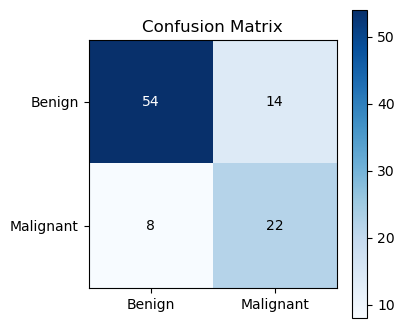

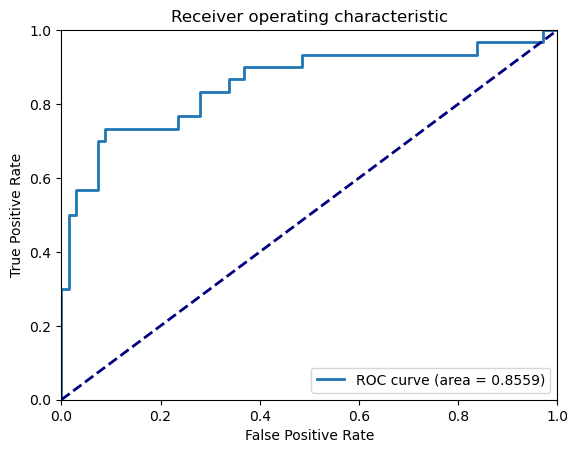

In [5]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Dense/best_model',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/InceptionV3_INbreast_DenseLayerTraining")

## Fine Tune

25/25 [==============================] - 1s 19ms/step


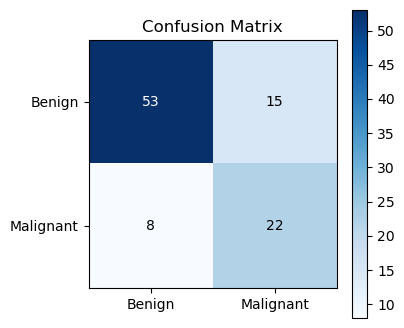

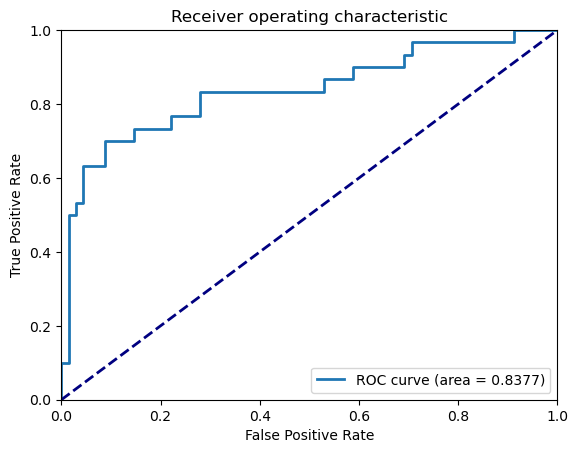

In [6]:
tf.keras.backend.clear_session()
# model.evaluate(test)
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/InceptionV3_INbreast_2FT")

## FT 2

25/25 [==============================] - 1s 15ms/step


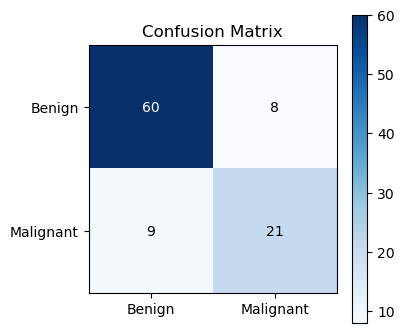

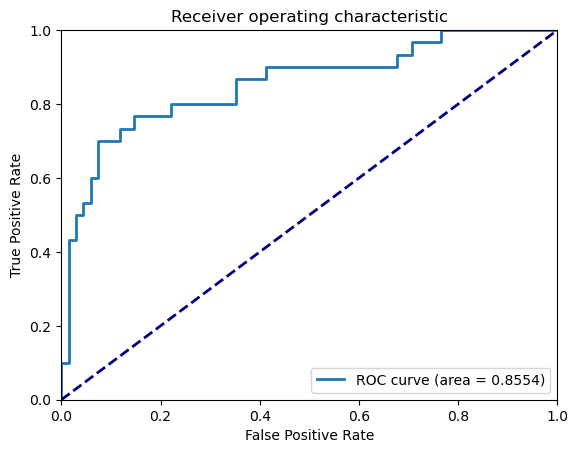

In [7]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=0),
          tf.keras.metrics.AUC()]

# model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Fine_Tune_2/best_model',metrics=metric)
model = Model_Training.build_model('inceptionv3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,
                                   img_height=img_height,img_width=img_width,training=False)
# model.load_weights(weights+'/Fine_Tune/best_model')
model.evaluate(test)

prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/InceptionV3_INbreast_FullFT")

# Resnet50

In [8]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_INbreast_COSINE/'
train_log = '/home/jj/FYP/log/Resnet50_INbreast_COSINE/'

25/25 [==============================] - 1s 14ms/step


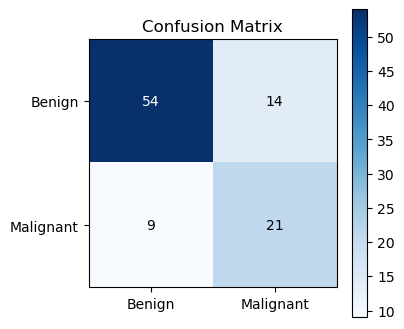

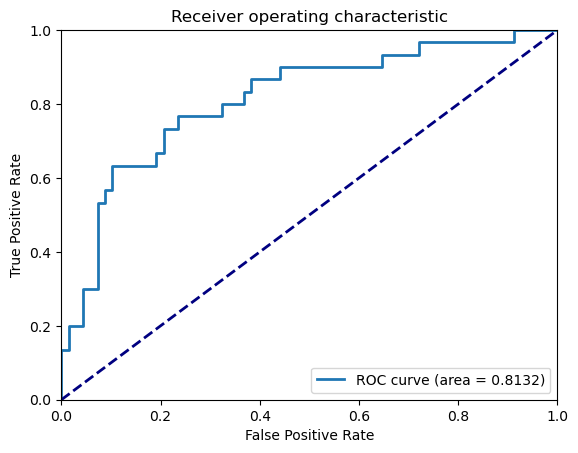

In [9]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Dense/best_model',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/ResNet50_INbreast_DenseLayerTraining")

## Fine Tune

25/25 [==============================] - 1s 13ms/step


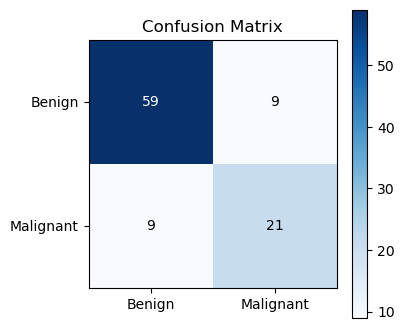

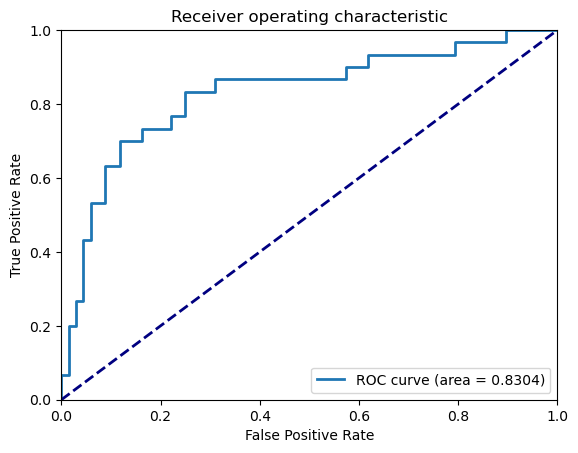

In [10]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_height=img_height,img_width=img_width)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/ResNet50_INbreast_2FT")

## FT2

25/25 [==============================] - 1s 12ms/step


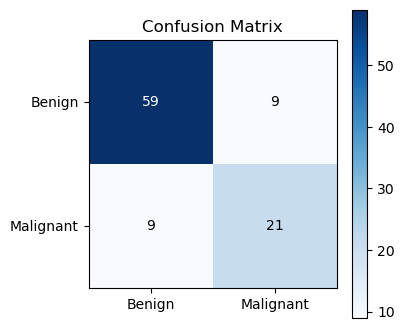

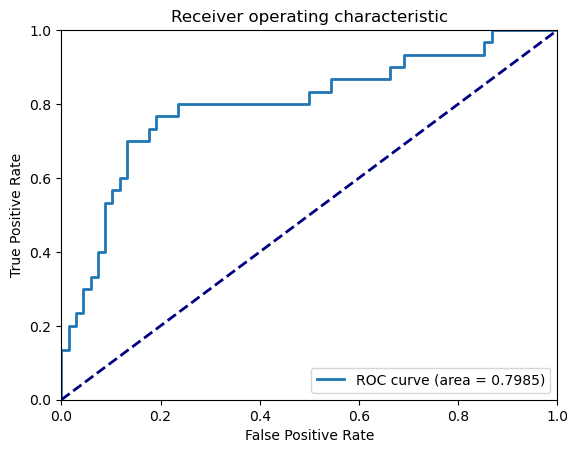

In [11]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/ResNet50_INbreast_FullFT")
tf.keras.backend.clear_session()

# VGG16

In [12]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_INbreast_COSINE/'
train_log = '/home/jj/FYP/log/Vgg16_INbreast_COSINE/'

25/25 [==============================] - 0s 10ms/step


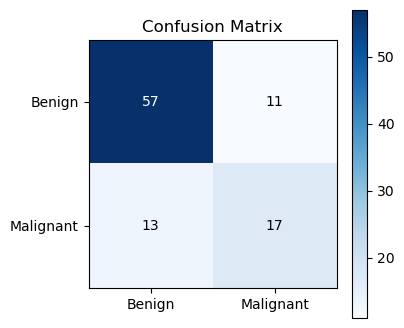

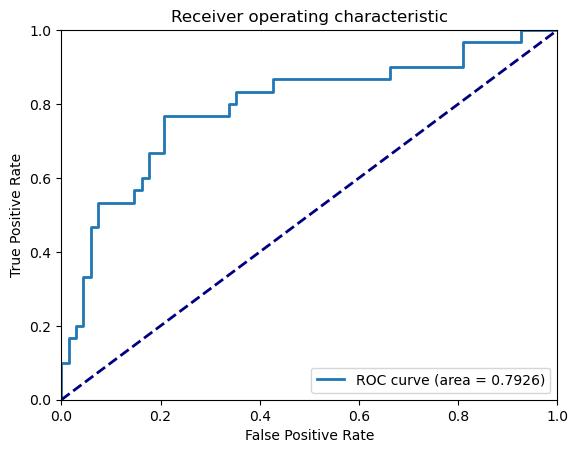

In [13]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('vgg16',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Dense/best_model',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/VGG16_INbreast_DenseLayerTraining")

## Fine Tune

25/25 [==============================] - 0s 10ms/step


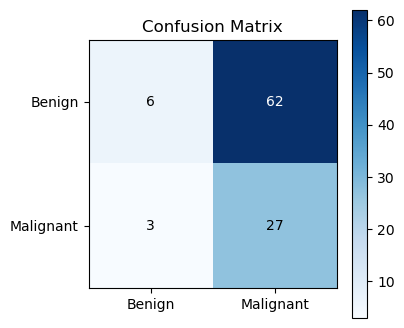

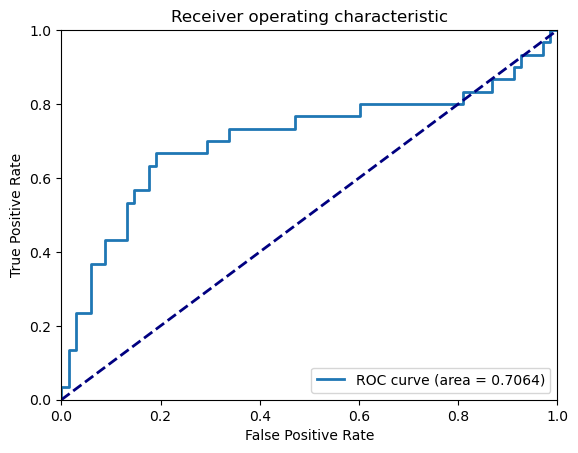

In [14]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('vgg16',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/VGG16_INbreast_2FT")

## FT2


25/25 [==============================] - 0s 10ms/step


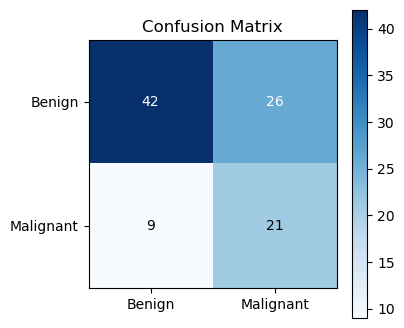

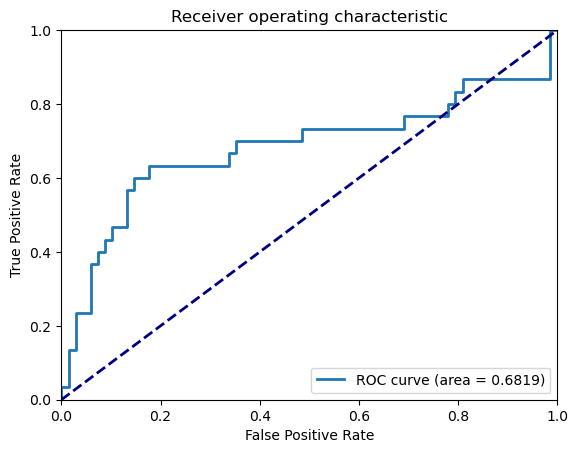

In [15]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('vgg16',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_width=img_width,img_height=img_height,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/VGG16_INbreast_FullFT")
tf.keras.backend.clear_session()

# EfficientNet

In [4]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_INbreast_COSINE/'
train_log = '/home/jj/FYP/log/EffcientNetB3_INbreast_COSINE/'

2023-05-02 21:22:15.661065: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 9/25 [=========>....................] - ETA: 0s - loss: 0.2638 - categorical_accuracy: 0.9167 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9799

2023-05-02 21:22:17.641121: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 2s 16ms/step


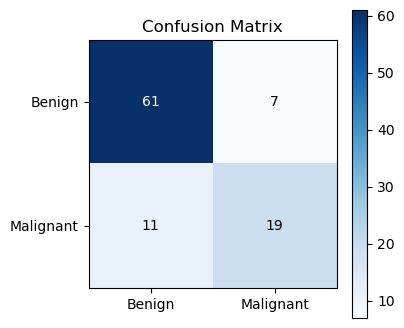

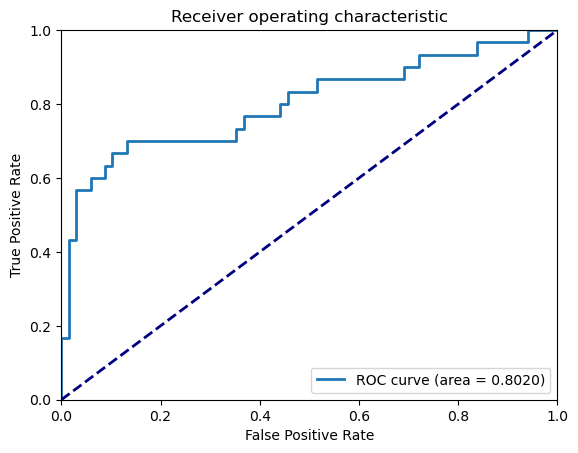

In [5]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Dense/best_model',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/EfficientNetB3_INbreast_DenseLayerTraining")

## Fine Tune

25/25 [==============================] - 2s 19ms/step


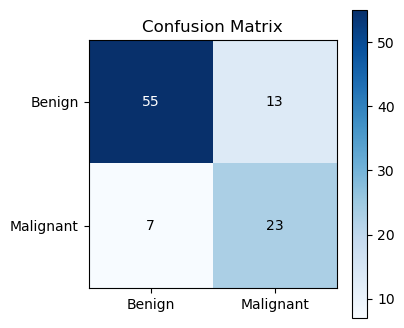

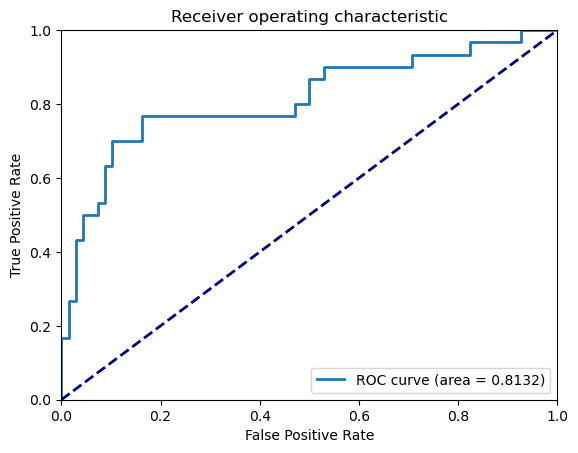

In [6]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_width=img_width,img_height=img_height)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/EfficientNetB3_INbreast_2FT")

## FT2

25/25 [==============================] - 2s 18ms/step


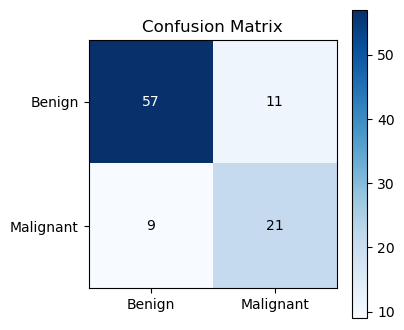

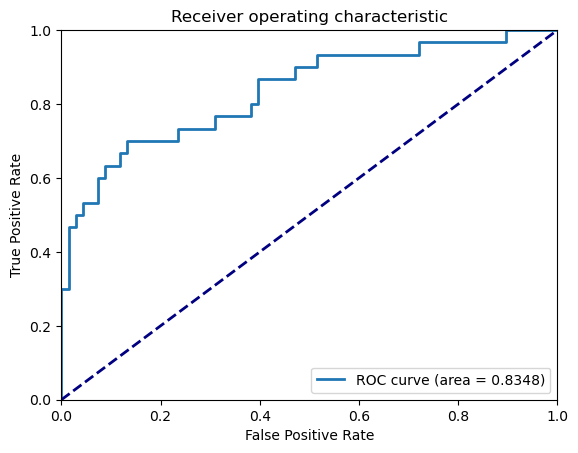

In [7]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_width=img_width,img_height=img_height,training=False)
# model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/EfficientNetB3_INbreast_FullFT")


# ConvNext

In [21]:
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_COSINE/'
train_log = '/home/jj/FYP/log/Convnext_INbreast_COSINE/'

2023-05-02 20:16:06.520472: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x23426290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-02 20:16:06.520697: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-05-02 20:16:07.110043: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 4s 83ms/step


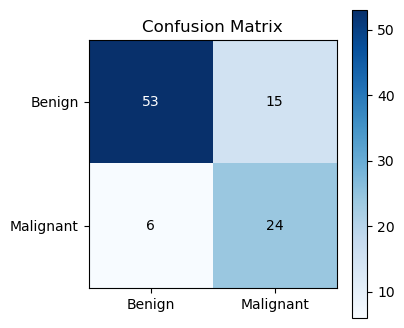

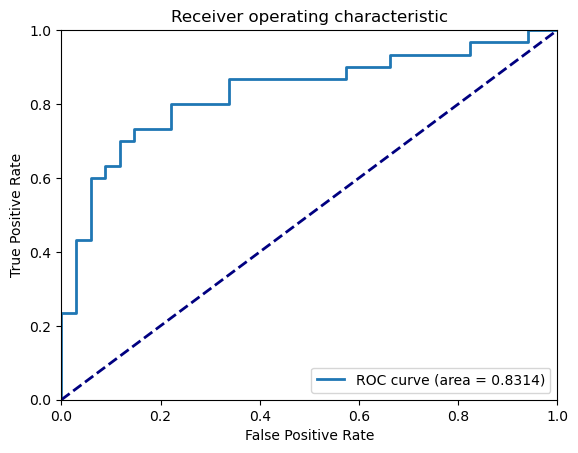

In [22]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Dense/best_model',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/ConvNext_INbreast_DenseLayerTraining")

## Fine Tune

25/25 [==============================] - 4s 79ms/step


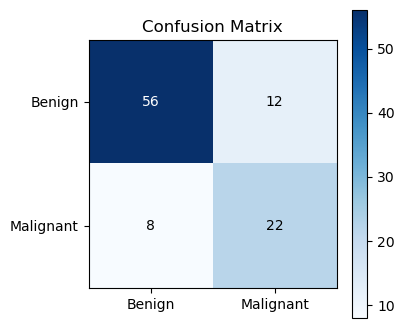

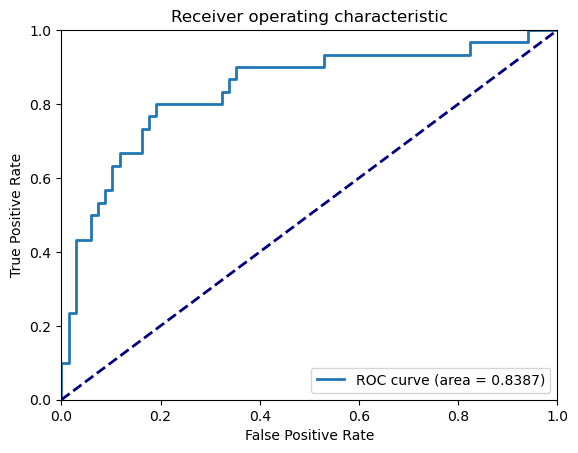

In [23]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric,img_height=img_height,img_width=img_width)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/ConvNext_INbreast_2FT")

## FT2

25/25 [==============================] - 4s 83ms/step


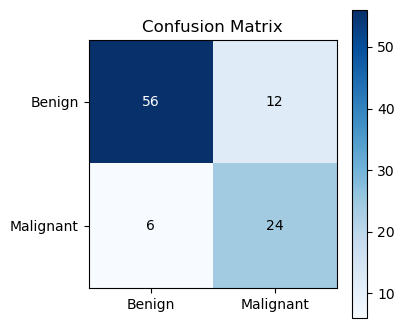

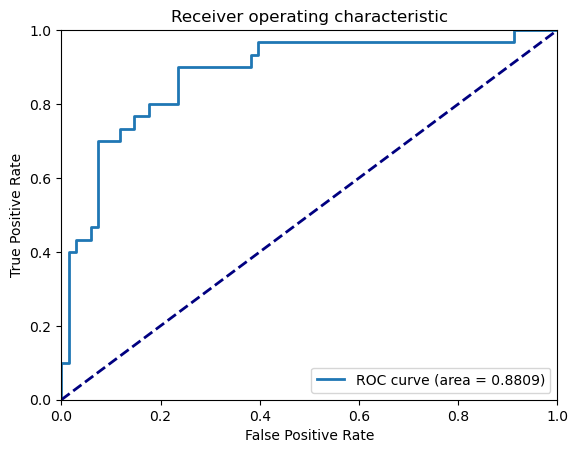

In [24]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/ConvNext_INbreast_FullFT")
tf.keras.backend.clear_session()

# EfficientNet V2M

## Initialising

In [25]:
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_INbreast_COSINE/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_INbreast_COSINE/'

 3/25 [==>...........................] - ETA: 0s - loss: 0.8664 - categorical_accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6736  

2023-05-02 20:18:14.014584: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 20:18:14.015888: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 20:18:14.056965: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 20:18:14.057020: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

25/25 [==============================] - 5s 57ms/step - loss: 0.5362 - categorical_accuracy: 0.7755 - precision: 0.6333 - recall: 0.6333 - auc: 0.8283


2023-05-02 20:18:15.377621: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 20:18:15.377671: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 20:18:15.417590: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 20:18:15.417643: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

25/25 [==============================] - 3s 42ms/step


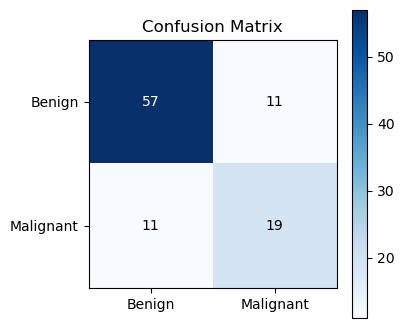

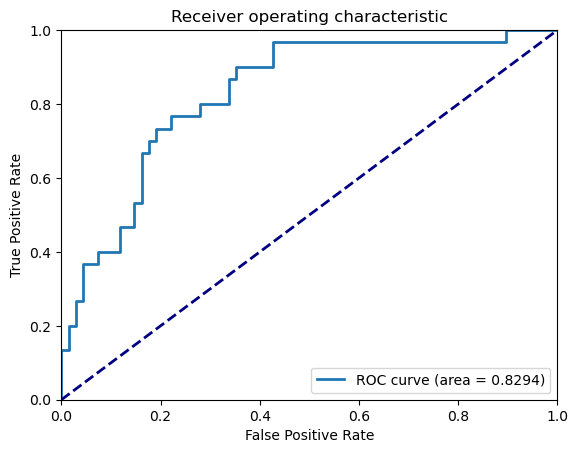

In [26]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Dense/best_model',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/EfficientNetV2M_INbreast_DenseLayerTraining")

## Fine Tuning

2023-05-02 20:19:53.682492: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 4s 36ms/step - loss: 0.5327 - categorical_accuracy: 0.7857 - precision: 0.6286 - recall: 0.7333 - auc: 0.8211


2023-05-02 20:19:57.664769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 4s 30ms/step


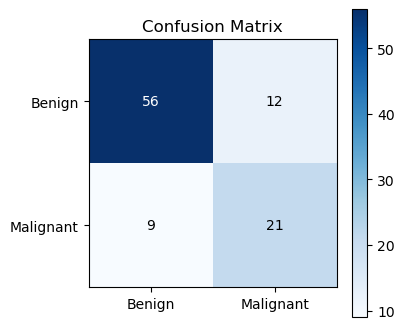

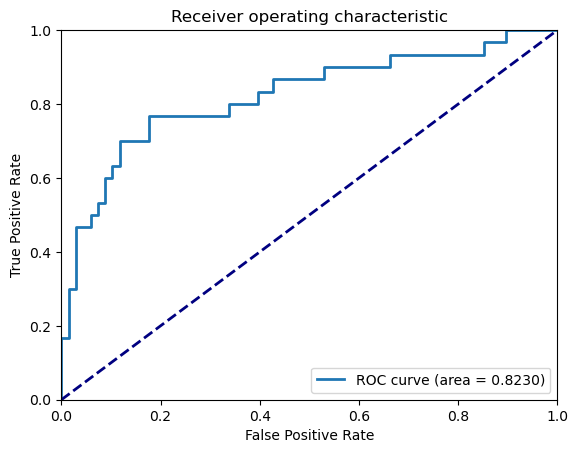

In [27]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final/Final',metrics=metric,img_height=img_height,img_width=img_width)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/EfficientNetV2M_INbreast_2FT")

## FT2

25/25 [==============================] - 4s 44ms/step


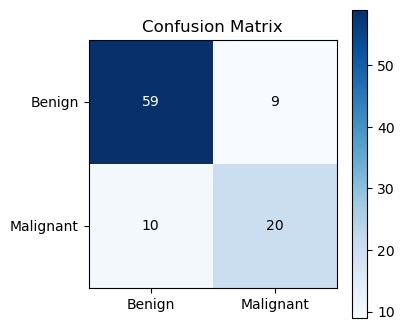

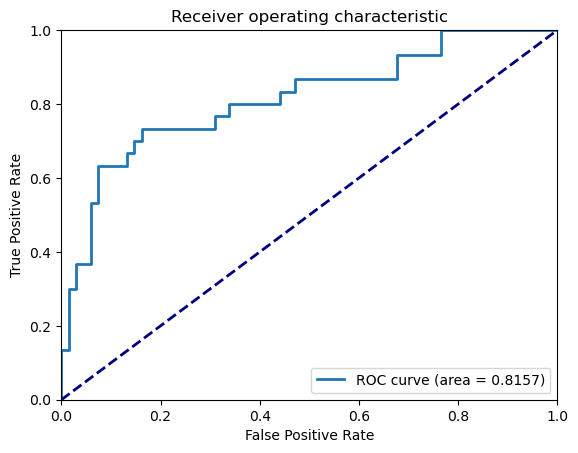

: 

In [28]:
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetv2m',augmentation=False,flatten='global_average_pooling',load_weights=weights+'Final_2/Final_2',metrics=metric,img_height=img_height,img_width=img_width,training=False)
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
model.save("/home/jj/FYP/Saved_Model/EfficientNetV2M_INbreast_FullFT")
tf.keras.backend.clear_session()